# Chapter 12 - Custom Models and Train with TensorFlow

目前为止，我们仅仅使用了TensorFlow的高级API，**tf.keras**，但是这已经帮助我们走得很远了：我们建立了各种各样的的网络结构，并使用了许多类似**批归一化， dropout，学习率计划**等技术。实际上，95%你遇到的的情况下，都只需要tf.keras(和tf.data，详情见第十三章)。但是，我们需要去更深层地了解TensorFlow，并去研究它的低级 Python API。这会非常有效：
* 当你需要对网络进行例如自定义的损失函数，评价标准，网络层，网络模型，初始化，正则化和权重限制等额外控制时。
* 你可能需要对训练循环本身进行完全地掌控，比如对梯度使用特殊的转化和限制(不仅仅是梯度裁剪),或者对网络的不同部分使用不同的优化器。

在本章中，我们会讨论上述所有情况。之后，我们也会了解如何提升你自定义的模型并使用Tensorflow 自动图生成特性对网络进行训练。但是首先，我们快速浏览一下 TensorFlow。

In [1]:
import sys
assert sys.version_info >= (3, 5)


import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os


np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 12.1 A Quick Tour of TensorFlow

如你所知道的，TensorFlows是一个强有力的数学计算库，特别适合于对大规模机器学习进行微调(但你也能把它用于其他需要大量计算的任何地方)。它于2015年9月开源，是目前最受欢迎的深度学习库。所以，TensorFlow实际上能提供哪些：
* 它与Numpy非常相似，但是它支持GPU加速。
* 它支持分布式计算(跨设备和服务器)。
*  它包括一种及时（JIT）编译器，这允许它优化计算速度和内存使用：它的工作方式是从Python函数中提取计算图，然后优化它（例如，通过修剪未使用的节点），最后高效地运行它（例如，通过自动并行运行独立操作）。
* 计算图可以导出为可移植的格式，因此你可以在一个环境中训练TensorFlow模型（例如，在Linux上使用Python），并在另一个环境中运行它（例如，在Android设备上使用Java）。
*  它实现了自动求导(见第10章)，并提供了一些优秀的优化器，如RMSProp、Nadam和FTRL(见第11章)，因此你可以轻松地将各种损失函数最小化。
* TensorFlow提供了更多的功能，建立在这些核心功能之上：最重要的当然是tf.keras，但它还有数据加载与预处理操作（tf.data、tf.io等）、图像处理操作（tf.image）、信号处理操作（tf.signal）等（见图12-1，TensorFlow的Python API概述）。

![image-20200819093036369](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/19/093038-767848.png)

>我们会涉及许多Tensorflow的包和函数，但是覆盖所有是不可能的。所以，你需要花时间去浏览他的API，你会发现，它的内容相当丰富，而且有据可查。

在底层，每个TensorFlow操作都是非常高效的C++代码实现的。许多操作有多个实现，被称为内核：每个内核专门用于特定的设备类型，例如CPU,GPU和TPU。

TensorFlow的结构如图12-2所示：你的大部分代码只需要使用高级API（特别是tf.keras和tf.data），但当你需要更高的灵活性时，你会使用低级Python API去直接处理张量。
![image-20200819094616674](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/19/094617-294608.png)
注意到，其他语言的API也是可以获取的:
* C++
* Java
* GO
* Swift
* Javascript

在许多情况中，只要你告诉它，TensorFlow的执行引擎会负责高效地运行操作，即使是跨多个设备和机器:
* Linux
* MacOS
* Windows
* mobile device（使用TensorFlow Lite）

最后，TensorFlow不仅仅是一个操作库，它还是是一个广泛的库的生态系统的中心，拥有一支充满激情、乐于助人的专业开发团队，背后还有一个庞大的社区去帮助提升它。

## 12.2 Using TensorFlow like Numpy

TensorFlow的API都围绕**tensor**展开，因此得名Tensor-Flow。张量通常为多维数组（就像一个NumPy ndarray一样），但它也可以是一个标量（一个简单的值）。当我们创建自定义损失函数，自定义评价标准，自定义层等时，这些张量非常重要。


### 12.2.1 Tensor and Operations

In [2]:
import tensorflow as tf
import numpy as np

使用tf.constant()创建一个张量：

In [3]:

tf.constant([[1., 2., 3.],[4., 5., 6.]]) # 2x3 矩阵

<tf.Tensor: id=0, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [4]:
tf.constant(42)  #标量

<tf.Tensor: id=1, shape=(), dtype=int32, numpy=42>

与 ndarray 一样， 一个 tf.Tensor也具有尺寸和数据类型

In [5]:
t = tf.constant([[1., 2., 3.],[4., 5., 6.]])
t.shape

TensorShape([2, 3])

In [6]:
t.dtype

tf.float32

与 Numpy 一样进行索引

In [7]:
t[:,1:]

<tf.Tensor: id=6, shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [8]:
print(t[...,1,tf.newaxis])

tf.Tensor(
[[2.]
 [5.]], shape=(2, 1), dtype=float32)


最重要的是，支持各种各样的张量操作

In [9]:
t + 10

<tf.Tensor: id=12, shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [10]:
tf.square(t)  # 张量内部元素开平方

<tf.Tensor: id=13, shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [11]:
t @  tf.transpose(t)  # 张量乘法

<tf.Tensor: id=16, shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

> 注意到，t + 10 与调用 tf.add(t, 10)一样。（Python调用魔法方法 t.\__add__(10)时，就会调用 tf.add(t,10)）。其他的操作（例如 -，\*）也都支持。@操作等同于调用 tf.matmul()函数

你会发现，你可以找到所有你需要的基本数学运算 (例如，tf.add(), tf.multiply(), tf.square(), tf.exp(), tf.sqrt()...), 以及更普遍的你可以在NumPy中找到的大多数运算 (例如。tf.reshape(), tf.squeeze(), tf.tile())，但有时会有不同的名称(例如，tf.reduce_mean(), tf.reduce_sum(), tf.reduce_max(), tf.math.log()相当于np.mean(), np.sum(), np.max()和np.log())。

名字不同是事出有因的：
* 在Tensor Flow中，必须写tf.transpose(t)，而不能像Numpy中写t.T。这是因为两者的操作有着本质的区别。在TensorFlow中，转置操作会生成新的张量，新张量的值为原张量的转置。而在Numpy中，仅仅改变数据的形式，并不会生成新的张量。
* 在TensorFlow中， tf.reduce_sum()操作之所以这样命名，是因为它的GPU内核(即GPU实现)使用的reduce算法不保证元素添加的顺序:因为32bit浮点数精度有限，因此你每次调用它，结果都会有小的变化。

> 许多函数和类都有别名。比如，tf.add()和tf.math.add()是同一个函数。这使得TensorFlow对于大多是常见操作都有简称，同时也使得包非常有条理。

Keras API也拥有自己的低级API,在keras.backend中。它包括square(),exp(),sqrt()等函数。在tf.keras中，这些函数通常只会调用相应的TensorFlow操作。如果你想编写可移植到其他Keras实现的代码，你就应该使用这些Kears函数。然而，它们只是TensorFlow提供函数的子集，所以在本书中，我们直接使用TensorFlow操作。

In [12]:
from tensorflow import keras

In [13]:
K = keras.backend

In [14]:
K.square(K.transpose(t)) + 10

<tf.Tensor: id=21, shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### 12.2.2 Tensor and Numpy

Tensors与NumPy配合得很好，你可以从一个Numpy数组中创建一个tensor，反之亦然。你甚至可以对Numpy数组采用TensorFlow操作，对tensor采用Numpy操作：

In [15]:
a = np.array([2., 4., 5.])

In [16]:
tf.constant(a)

<tf.Tensor: id=22, shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [17]:
t.numpy()  # 或者是 np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [18]:
tf.square(a)   # 对 Numpy 数组使用 TensorFlow操作

<tf.Tensor: id=24, shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [19]:
np.square(t)   #对 tensor 采用 Numpy 操作

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

> 注意，Numpy默认采用64bit精度，而TensorFlow使用32bit精度。这是因为32bit精度对于神经网络已经足够了，另外它的运行速度更快，使用的内存更少。所以当你从Numpy数组中创建tensor时，确保 dtype = tf.float32。

### 12.2.3 Type Conversions

类型转换会严重影响表现，而它们在自动完成后，很容易被人忽视。为了避免这一点，**TensorFlow不会自动执行任何类型转换**。当你对不兼容类型tensor尝试执行操作时，它只是引发一个异常。比如：浮点型tensor不能与整型tensor相加，32bit浮点型不能与64bit浮点型相加：

In [20]:
tf.constant(2.) + tf.constant(40)  #整型与浮点型

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2] name: add/

In [21]:
tf.constant(2.) + tf.constant(40,dtype = tf.float64)  # 32bit 与 64bit

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2] name: add/

一开始可能会有点烦，但要记住，这是为了做好事! 当然，如果你想进行类型转换，你可以使用**tf.cast()**：

In [22]:
t2 = tf.constant(40.,dtype = tf.float64)

In [23]:
tf.constant(2.0) + tf.cast(t2,tf.float32)   #将 tf.float64 转换为 tf.float32

<tf.Tensor: id=32, shape=(), dtype=float32, numpy=42.0>

### 12.2.4 Variables

目前，我们使用了常量tensor：如名字所示，你不能改变它们的值。然而，神经网络中的权重在反向传播中进行微调，而其他的参数也需要随着时间推移而改变（比如，动量优化器追踪过去的梯度）。我们需要的是**tf.Variable()**:

In [24]:
v = tf.Variable([[1., 2., 3.],[4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

一个tf.Variable的作用很像一个常量张量：你可以对它进行相同的操作，且它与Numpy配合地很好，只是对类型有些挑剔。但它可以用assign()方法原地修改。你也可以切片修改：

In [25]:
v.assign(2 * v)     #  => [[2., 4., 6.], [8., 10., 12.]] 
v[0,1].assign(42)   # => [[2., 42., 6.], [8., 10., 12.]]
v[:, 2].assign([0., 1.])  # => [[2., 42., 0.], [8., 10., 1.]]
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.]) # => [[100., 42., 0.], [8., 10., 200.]]

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

在实际情况中，你很少需要去手动创建变量。因为Keras提供add_weight()方法，它会帮助你注意这一点。不仅如此，模型参数一般由优化器直接更新。你几乎不需要去手动更新变量

### 12.2.5 Other Data Structure

TensorFlow支持如下一些数据结构：
* **Sparse tensor(tf.SparseTensor)**能有效表示包含大量0值的tensor。tf.sparse包包含sparse tensor的操作。
* **Tensor arrays(tf.TensorArray)**是tensor列表。默认情况下，它们具有固定尺寸，但也可以选择动态化。它包含的所有tensor必须拥有相同的尺寸和数据类型。
* **Ragged tensors(tf.RaggedTensor)**表示静态tensor列表的列表，其中所有的tensor必须有同样的尺寸和数据类型。tf.ragged包包含相应的操作。
* **String tensors**是常规的tf.string类型的tensor。它们实际表示字符串，而不是Unicode串。所以，如果你使用Unicode串（比如一个常见的 Python 3 字符串"cafe"）创建string tensor，它会自动编码为UTF-8（ b"caf\xc3\xa9"）。或者，你可以使用tf.int32的tensors表示Unicode strings。其中，tensor的每一项表示一个码点 （比如：[99, 97, 102, 233])。tf.strings包包含相应的操作。
* **Sets**只是表示为包含一个或多个集合的常规tensor（或稀疏tensor），你可以使用tf.set包中的操作来操作它们。
* **Queue**包含先进先出队列，优先处理队列，随机队列和补零队列。这些类都在tf.queue包中。

有了tensors、运算、变量和各种数据结构供你支配，你现在已经准备好定制你的模型和训练算法了!

## 12.3 Customizing Models and Training Algorithms

### 12.3.1 Custom Loss Function

假定你想要训练一个回归模型，但是你的训练集带有一定的噪声。当然，你可以通过移除或修改异常值来清洗数据。但这通常不够，数据仍然带有噪声。你应该使用哪个损失函数？均方误差可能会对大误差惩罚过多，所以你的模型可能不够精确。平均绝对误差不会惩罚太多，但是训练需要一段时间才能收敛，训练后的模型也不会很精确。这时可能需要**Huber loss**（第十章引入）而不是MSE。Huber loss目前并不是官方Keras API的一部分。但是tf.keras有提供（只需要使用keras.losses.Huber类的实例）。但让我们假设不存在。我们只需要创建一个函数，这个函数将标签和预测作为参数，使用TensorFlow操作去计算每一个样本的损失：

In [26]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [27]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)  # 用于判断返回哪一种损失

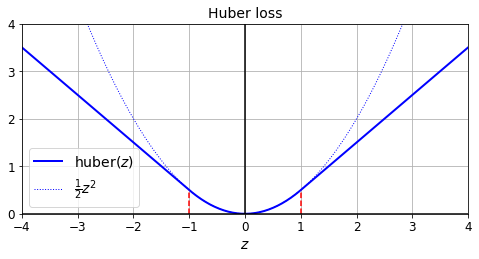

In [28]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

为了有更好的表现，你应该考虑向量化实现（如同示例中）。不仅如此，如果你想从TensorFlow图特性中收益，你应该只使用TensorFlow操作。

最好是返回一个包含每个实例的损失的tensor，而不是返回平均损失。如此一来，Keras可以在要求时应用类权重或样本权重（见第10章）。

接着，当编译Keras模型时，你可以使用这个损失，然后训练你的模型：

In [29]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"]) # 使用自定义损失

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 2s 133us/sample - loss: 0.6280 - mae: 0.9992 - val_loss: 0.2920 - val_mae: 0.5975
Epoch 2/2
11610/11610 [==============================] - 0s 41us/sample - loss: 0.2203 - mae: 0.5187 - val_loss: 0.2324 - val_mae: 0.5196


在训练过程中，对于每一个批次，Keras都会调用huber_fn()函数来计算损失。并根据它进行梯度下降。 此外，它将跟踪自开始的时代以来的总损失，并将显示平均损失。

### 12.3.2 Saving and Loading Models That Contain Custom Components

保存包含自定义损失函数的模型时可行的，因为Keras只保存函数的名字。然而，当你加载它的时候，你都要提供一个字典，将**函数名字映射到实际的函数**。更一般地说，当你加载的模型包含自定义对象（包括自定义损失函数，自定义层和自定义评价标准等）时，你都需要去把名字映射到对象：

In [30]:
model.save("my_model_with_a_custom_loss.h5") # 保存模型

In [31]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn}) #加载模型

In [32]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 62us/sample - loss: 0.2051 - mae: 0.4976 - val_loss: 0.2206 - val_mae: 0.5103
Epoch 2/2
11610/11610 [==============================] - 0s 39us/sample - loss: 0.2004 - mae: 0.4907 - val_loss: 0.2026 - val_mae: 0.4851


按照目前的执行情况，任何值在-1和1之间的误差都被认为是小的。但是，假如我们想要一个不同的阈值呢？一个解决方法就是创建一个配置损失函数：

In [33]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

model.compile(loss = create_huber(2.0), optimizer = "nadam")

In [34]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 76us/sample - loss: 0.2213 - val_loss: 0.2422
Epoch 2/2
11610/11610 [==============================] - 0s 40us/sample - loss: 0.2183 - val_loss: 0.2075


不幸的是，**当你保存模型时，阈值并不会被保存**。这意味着当你加载模型的时候，你必须去指定阈值的值。注意：使用的名字是"huber_fn",这时我们给Kears的名字，而不是创造它的函数的名字）：

In [35]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [36]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [37]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 66us/sample - loss: 0.2135 - val_loss: 0.2246
Epoch 2/2
11610/11610 [==============================] - 0s 40us/sample - loss: 0.2121 - val_loss: 0.2025


你可以通过创建`keras.losses.Loss`子类的方法去解决，并执行它的`git_config()`方法：

In [38]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold = 1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
        
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

我们先来看看这段代码：
* 构造函数接收`**kwargs`，并把他们传递给父类构造函数。父类构造函数会处理标准的超参数：损失的名字，用于聚合单个实例损失的约简算法。默认情况下为`sum_over_batch_size`，这意味着损失为实例损失之和，可能是样本权重的加权，如果有的话，然后将结果除以批次大小（而不是权重的总和，所以这不是加权平均值）。其他的可能值为`sum`或`None`。
* `call()`方法接收标签和预测，计算所有实例的损失，并返回它们。
* `get_config()`方法返回一个将每个超参数名字映射到对应值的字典。它首先调用父类的`git_config`方法，然后往这个字典中添加新的超参数（{\*\*x}简写句法在Python 3.5时加入）。

当你编译模型时，你可以使用这个类的任意实例：

In [39]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [40]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [41]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 74us/sample - loss: 0.6910 - mae: 0.8770 - val_loss: 0.3483 - val_mae: 0.5618
Epoch 2/2
11610/11610 [==============================] - 0s 40us/sample - loss: 0.2404 - mae: 0.5084 - val_loss: 0.2373 - val_mae: 0.4873


当你保存模型的时候，阈值也会随着模型的保存而一起保存。当你加载模型的时候，你只需要去把类的名字映射到类本身即可：

In [42]:
model.save("my_model_with_a_custom_loss_class.h5")

In [43]:
# 示意代码，不能执行
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                               custom_objects={"HuberLoss":HuberLoss})

ValueError: Unknown loss function: HuberLoss

* 当你保存模型时，Keras会调用损失实例的`get_config()`方法，并把信息保存以JSON格式保存至HDF5文件中。
* 当你加载模型时，它会调用`from_config`方法类。这个方法通过基础类（Loss）实现。只需要创造这个类的实例，将`**config`传给构造函数即可。

Keras API只指明如何使用子类去定义层，模型，回调和正则化。如果你想使用子类去建立其他的部分（比如损失，评价标准，初始化和限制），它们可能无法移植到其他Keras实现中。

### 12.3.3 Custom Activation Function, Initializers, Regularizers, and Constraints

大部分Keras的功能，例如损失，正则化，限制，初始化，评价标准，激活函数，层和甚至整个模型等，都可以通过非常类似的方法自定义。大多数时候，你只需要写一个带有正确输入和输出的简单函数：

In [44]:
keras.backend.clear_session() #清空

In [45]:
#  自定义激活函数
def my_softplus(z):  #与 tf.nn.softplus一样
    return tf.math.log(tf.exp(z) + 1.0)

#自定义Glorot初始化
def my_glorot_initializer(shape, dtype = tf.float32):
    stddev = tf.sqrt(2./(shape[0] + shape[1]))
    return tf.random.normal(shape, stddev = stddev, dtype = dtype)

#自定义L1正则化
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

# 自定义限制
def my_positive_weights(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)  

如你所见，参数取决于自定义函数的类型。这些自定义函数都可以被正常使用：

In [46]:
layer = keras.layers.Dense(30, activation = my_softplus,
                          kernel_initializer = my_glorot_initializer,
                          kernel_regularizer = my_l1_regularizer,
                          kernel_constraint = my_positive_weights)

* 激活函数会被用于这一层的输出，其结果会传递到下一层。
* 层的权重会被初始化为初始化器返回的值。
* 训练的每一步，权重都会传递至正则化函数去计算正则化损失。这一损失将会添加到损失函数中去，以得到用于训练的最终损失。
* 在每一步训练之后，限制函数都会被调用，每一层的权重会被限制权重所代替。

In [47]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [48]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [49]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 96us/sample - loss: 1.3664 - mae: 0.8386 - val_loss: nan - val_mae: nan
Epoch 2/2
11610/11610 [==============================] - 0s 40us/sample - loss: 0.6616 - mae: 0.5520 - val_loss: 2.9425 - val_mae: 0.5451


如果一个函数中的超参数需要和模型一起保存，你需要去构建合适的子类，比如：`keras.regularizers.Regularizer`,`keras.constraints.Constraint`,`keras.initializers.Initializer`或者`keras.layers.Layer`。

In [50]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
        
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    
    def get_config(self):
        return {"factor": self.factor}

In [51]:
keras.backend.clear_session()

In [52]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [53]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [54]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 75us/sample - loss: 1.7131 - mae: 0.8994 - val_loss: nan - val_mae: nan
Epoch 2/2
11610/11610 [==============================] - 0s 40us/sample - loss: 0.6885 - mae: 0.5480 - val_loss: nan - val_mae: nan


你必须实现损失，层（包括激活函数）和模型的`call()`和正则化，初始化和限制的`__call__()`方法。对于评价标准，会有一些不同，我们将在后续章节介绍。

### 12.3.4 Custom Metrics

损失函数和评价标准本质上是不一样的：
* 损失将被用于梯度下降，所以必须是可导的。
* 损失的梯度不能每一处都是0。
* 另外，如果损失不容易被人们解读也是可以的（例如交叉熵）。

相对应的是，评价标准用于评价模型：
* 评价标准可以不可导。
* 评价标准导数处处为0（例如，准确率）。
* 评价标准必须能被我们轻松理解。

也就是说，在大多数情况下，定义一个自定义的度量函数和定义一个自定义的损失函数是完全一样的。实际上，我们甚至可以使用 Huber 损失函数作为评价标准：

In [55]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [56]:
#  示意代码，不能运行
model.compile(loss = "mse", optimizer = "nadam", metrics= [create_huber(2.0)])

In [57]:
model.fit(X_train_scaled, y_train, epochs=2)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 69us/sample - loss: 2.7004 - huber_fn: 1.1336
Epoch 2/2
11610/11610 [==============================] - 0s 31us/sample - loss: 0.6378 - huber_fn: 0.3021


对于训练过程中的每个批次， Keras将计算这个评价标准，并跟踪其自epoch开始以来的平均值。大多数情况下，这正是你想要的。但并非总是如此 例如，考虑一个二进制分类器的精度。如我们在第三章所看到的，精度是指真阳性数除以阳性预测数（包括真阳性和假阳性）。

假设模型在第一批中做出了5个正面预测，其中4个正确：那就是80%的精度。那么假设模型在第二批中做了3个正面预测，但都不正确：那第二批的精度是0%。如果你只计算这两个精度的平均值，就会得到40%。但等一下，这不是模型在这两批中的精度! 事实上，在8个阳性预测（5+3）中，共有4个真正的阳性（4+0），所以总体精度是50%，而不是40%。

我们需要的是一个对象，它可以跟踪真阳性和假阳性的数量，并在请求时计算它们的比率。这正是 keras.metrics.Precision 类所做的事情：

In [58]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: id=30438, shape=(), dtype=float32, numpy=0.8>

In [59]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: id=30485, shape=(), dtype=float32, numpy=0.5>

在这个例子中，我们创建了一个Precision对象，然后我们像使用函数一样使用它，向它传递第一个批次的标签和预测，然后是第二个批次的标签和预测（注意，我们也可以传递样本权重）。我们使用的真阳性和假阳性的数量与我们刚才讨论的例子相同。第一个批次之后，它返回的精度是80%，第二个批次之后，它返回的精度是50%（这是目前为止的整体精度，不是第二个批次的精度）。这被称之为**流式指标**，因为它在一批又一批之后缓慢更新。 

在任何时候，我们都可以调用result()方法来获取评价标准的当前值。我们也可以使用`variables`属性知道它的变量（追踪真阳性和假阳性的数量）。并使用`reset_states()`方法重置这些变量：

In [60]:
precision.result()  # 书上的代码有错误，应该是 precision.result(),而不是p.result()

<tf.Tensor: id=30494, shape=(), dtype=float32, numpy=0.5>

In [61]:
precision.variables  #同上

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [62]:
precision.reset_states()   # 同上，所有变量都置为0

如果你需要去创建一个这样的流式指标，你可以创建一个`kersa.metrics.Metric`类的子类。这里有一个简单的例子，它可以跟踪总的Huber损失和目前看到的实例数量。当问及结果时，它将返回比率，也就是简单的Huber损失平均值：

In [63]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold = 1.0, **kwargs):
        super().__init__(**kwargs) # 处理基础参数
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer = "zeros")#添加状态变量,初始化为0
        self.count = self.add_weight("count", initializer = "zeros")# 同上
        
    def update_state(self, y_true, y_pred, sample_weight = None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
        
    def result(self):
        return self.total / self.count
    
    def get_config(self):
        base = super().get_config
        return {**base_config, "threshold":self.threshold}

让我们浏览一下代码：
* 构造函数使用`add_weight()`方法创建变量，以跟踪度量在多个批次中的评价标准状态，在这种情况下，所有Huber损失的总和（total）和到目前为止看到的实例数量（count）。如果你愿意，你可以手动创建变量。Keras可以跟踪任何设置为属性的tf.Variable（更一般地说，任何 "可跟踪 "的对象，如层或模型）。
* 当你调用这个类的实例作为函数时，`update_state()`方法会被调用。它更新给定的一个批次的标签和预测的变量（以及样本权重，但在这种情况下，我们只是忽略它们）。
* `result()`方法计算并返回最终结果。在本例中只是所有实例的平均Huber评价标准。当你把评价标准作为一个函数使用时，update_state()方法首先被调用，然后调用result()方法，并返回其输出。
* 我们也实现了`get_config()`方法，以确保阈值能够跟着模型一起被保存。
* `reset_states()`方法的默认实现只是将所有变量重置为0.0（但如果需要的话，你可以重写它）。

Keras将无缝处理变量的持久性，不需要任何操作。

当你使用一个简单的函数定义一个评价标准时，Keras会自动为每一个批次调用它，并且它在每个时间段都会跟踪平均值，就像我们手动做的那样。所以我们的HuberMetric类的唯一好处就是会保存阈值。

当然，有些评价标准，比如精度，不能简单地对批次进行平均：在这种情况下，除了实现流式指标，没有其他选择。

### 12.3.5 Custom Layers

你可能偶尔会想要构建一个包含外来层的架构，而TensorFlow没有为其提供默认实现。在这种情况下，你将需要创建一个自定义层。或者有时你可能只是想构建一个非常重复的架构，包含重复多次的相同的层块，将每个层作为一个单层来处理会很方便。比如，如果模型是一系列层：A,B,C,A,B,C,A,B,C。那你可能想定义一个包含层A,B,C的自定义层D。你的模型将会变为简单的D,D,D。

首先，有些图层没有权重，例如`keras.layer.Flatten`或`keras.lay ers.ReLU`。如果您想创建一个没有任何权重的自定义图层，最简单的方法是编写一个函数，并将其封装在 `keras.layer.Lambda`层中。例如，以下图层将对其输入应用指数函数:

In [64]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

然后，可以像其他层一样使用这个自定义层，使用顺序API、功能API或子类API。你也可以把它作为一个激活函数来使用（或者你可以直接使用`activation=tf.exp`，或者 `activation=keras.activations.exponential`,或者简单的`activation="exponential"`）。

你现在可能已经猜到了，要构建一个自定义的有状态的层（即带有权重的层），你需要创建一个keras.layer.Layer类的子类。例如，下面的类实现了Dense层的简化版本:

In [65]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation = None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name = "kernel", shape = [batch_input_shape[-1],self.units],
            initializer = "glorot_normal")
        self.bias = self.add_weight(
            name = "bias", shape=[self.units],
            initializer = "zeros")
        super().build(batch_input_shape) #必须在最后
        
    def call(self,X):
        return self.activation(X @ self.kernel + self.bias)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:1] + [self.units]) #as_list()返回此形状的尺寸列表
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units":self.units,
               "activation" : keras.activations.serializer(self.activation)}

In [66]:
keras.backend.clear_session()

In [67]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [68]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 68us/sample - loss: 1.8091 - val_loss: 1.4563
Epoch 2/2
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5656 - val_loss: 0.4901
5160/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.4994763313337814

让我们浏览一下代码：
* 构造函数将所有的超参数作为参数（在本例中只是units和activation），重要的是它还接受一个\*\*kwargs参数。它调用父构造函数，将kwargs参数传递给它：这将处理标准参数，如input_shape、trainingable、name等。然后它将超参数保存为属性，使用`keras.activations.get()`函数将激活参数转换为相应的激活函数（它接受函数、标准字符串，如 "relu "或 "selu"，或者干脆就是None）。
* `build()`方法的作用是创建层变量，这通过对每个变量调用`add_weight()`实现。第一次使用该层时，会调用build()方法。这时，Keras会知道这个层的输入形状，并将其传递给build()方法，这对于创建一些权重往往是必要的。例如，我们需要知道上一层的神经元数量，以便创建连接权重矩阵（即 "kernel"）：这对应于输入的最后一个维度的大小。在build()方法的最后（也只有在最后），你必须调用父层的build()方法：这将告诉Keras该层已经构建完成（它只是设置self.build = True）。
* `call()`方法实际上是在执行所需的操作。在这种情况下，我们计算输入X和层的内核的矩阵乘法，然后添加偏置向量，我们对结果应用激活函数，这就得到了层的输出。、
* `compute_output_shape()`方法只是简单地返回这层输出的形状。在这种情况下，它和输入的形状是一样的，只是最后一个维度被替换为层中神经元的数量。请注意，在 tf.keras中，形状是 tf.TensorShape类的实例，你可以使用 as_list() 将其转换为 Python 列表。
* `get_config()`方法与之前一样。注意，我们通过调用**keras.activations.serialize()**来保存激活函数的完整配置。

一般来说，你可以省略compute_output_shape()方法，因为tf.keras会自动推断输出形状，除非图层是动态的（我们将在后面看到）。在其他的Keras实现中，这个方法要么是必需的，要么默认为输出形状与输入形状相同。

* 要创建一个有多个输入的层（例如，Concatenate），call()方法的参数应该是一个包含所有输入的元组，同样，compute_output_shape()方法的参数也应该是一个包含每个输入的批次尺寸的元组。
* 要创建一个有多个输出的图层，call()方法应该返回输出的列表，compute_output_shape()应该返回批量输出形状的列表（每个输出一个）。

例如，下面的toy层需要两个输入并返回三个输出:

In [69]:
class MyMultiLayer(keras.layers.Layer):
    def call(self,X):  #参数传入元组
        X1, X2 = X
        return [X1+X2, X1*X2, X1/X2]
    
    def compute_output_shape(self, batch_input_shape):
        b1, b2 = batch_input_shape
        return [b1, b1, b1]  # 三个输出，所以为三个。且需要处理广播规则 

现在这个层可以像其他层一样使用，当然只能使用功能API和子类API，**而不是顺序API（只接受一个输入和一个输出的层）**。

如果你的层在训练和测试期间需要有不同的行为（例如，如果它使用Dropout或BatchNormalization层），那么你必须在call()方法中添加一个training参数，并使用这个参数来决定做什么。例如，让我们创建一个层，在训练期间添加高斯噪声（用于正则化），但在测试期间不做任何事情（Keras实际上有一个层做同样的事情：keras.layer.GaussianNoise）:

In [70]:
class MyMutiLayer(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
        
    def call(self, X, training = None):
        if training:
            noise = tf.random.normal(tf.shape(x), stddev = self.stddev)
            return X + noise
        else :
            return X
        
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

### 12.3.6 Custom Models

我们已经在第10章了解过自定义模型类，当时我们讨论的是子类API。其实很简单，只要将keras.mod els.Model类子类化，在构造函数中创建层和变量，然后实现call()方法，就可以实现你想要模型做的任何事情。比如，假设你想要建立一个如图12-3所示的模型：
![image-20200820190620842](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/20/190623-426886.png)

输入经过第一个精密层，然后经过由两个致密层和一个加法运算组成的残差块（我们将在第14章中看到，一个残差块将输入加到输出上），然后再通过这个相同的残差块3次，再通过第二个残差块，最后的结果要通过一个密集的输出层。请注意，这个模型并没有什么意义，它只是一个例子，以说明你可以很容易地建立任何一种你想要的模型，甚至是包含循环和跳跃连接。要实现这个模型，最好先创建一个ResidualBlock层，因为我们要创建几个相同的块（我们可能想在另一个模型中重复使用它）：

In [71]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

这个层有点特殊，因为它包含了其他层。这一点由Keras透明地处理：它自动检测到**隐藏属性**包含可跟踪对象（在本例中是层），因此它们的变量会自动添加到这个层的变量列表中。这个类的其余部分是不言自明的。接下来，让我们使用子类API来定义模型本身：

In [72]:

class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [73]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_test_scaled)

Train on 11610 samples
Epoch 1/5
11610/11610 [==============================] - 1s 119us/sample - loss: 24.3904
Epoch 2/5
11610/11610 [==============================] - 1s 47us/sample - loss: 2.21700s - loss: 2.448 - ETA: 0s - loss
Epoch 3/5
11610/11610 [==============================] - 1s 47us/sample - loss: 3.67750s - los
Epoch 4/5
11610/11610 [==============================] - 1s 47us/sample - loss: 6.7255
Epoch 5/5
11610/11610 [==============================] - 1s 45us/sample - loss: 1.2560
5160/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

我们在构造函数中创建层，并在call()方法中使用它们。然后，这个模型可以像其他模型一样使用（编译它、拟合它、评估它并使用它进行预测）。如果你还希望能够使用save()方法保存模型，并使用keras.models.load_model()函数加载模型，你必须在ResidualBlock类和ResidualRegressor类中实现get_config()方法（就像我们之前做的那样）。另外，你也可以使用save_weights()和load_weights()方法保存和加载权重。模型类实际上是层类的一个子类，所以模型可以像层一样被定义和使用。但是模型也有一些额外的功能，其中当然包括**compile(), fit(), evaluate()和predict()**方法（和一些不一样的，比如：train_on_batch()和fit_generator()）。

所以，如果模型比层提供更多的功能，为什么不直接将每个层定义为一个模型呢？好吧，从技术上讲，你可以这样做，但是把你的模型的内部组件（层或可重用的层块）和模型本身区分开来可能更干净。前者应该是Layer类的子类，而后者应该是Model类的子类。

有了这些，你就可以很自然、很简洁地构建几乎任何你在论文中找到的模型，可以使用顺序API、函数式API、子类API，甚至是这些的混合。"几乎 "任何模型？是的，我们还需要看几件事：第一，如何根据模型内部定义损失或指标，第二，如何构建一个自定义的训练循环。

### 12.3.7 Losses and Metrics Based on Model Internals

我们之前定义的自定义损失和指标都是基于标签和预测（以及可选的样本权重）。然而，你偶尔会希望**根据模型的其他部分来定义损失**，例如其隐藏层的权重或激活函数。这对于正则化的目的，或者监控模型的某些内部方面可能是有用的。

要基于模型内部定义一个自定义的损失，只需基于你想要的模型的任何部分进行计算，然后将结果传递给add_loss()方法。比如：接下来的自定义模型表示具有5个隐藏层的多层感知机回归器。假设它使用重建损失，我们在最后一个隐藏层的基础上，增加额外的Dense层。额外增加层的作用是重建模型的输入。由于重建的形状必须与模型的输入相同，我们需要在build()方法中创建这个Dense层，以便能够获得输入的形状。在call()方法中，我们同时计算MLP的常规输出，加上重建层的输出。

然后我们计算重建和输入之间的均方差，我们通过调用add_loss()将这个值（乘以0.05）添加到模型的损失列表中。在训练过程中，Keras将把这个损失添加到主损失中（这就是为什么我们缩小了重建损失的规模，以确保主损失占主导地位）。因此，模型将被迫通过隐藏层保留尽可能多的信息，甚至是对回归任务本身不直接有用的信息。在实践中，这种损失有时会改善泛化，它是一种正则化损失：

In [74]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        # TODO: check https://github.com/tensorflow/tensorflow/issues/26260
        #self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        #if training:
        #    result = self.reconstruction_mean(recon_loss)
        #    self.add_metric(result)
        return self.out(Z)

In [75]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 128us/sample - loss: 0.7969
Epoch 2/2
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4136


同样，你可以通过任何你想要的方式计算来添加基于模型内部的自定义评价标准，只要结果是评价标准对象的输出即可。例如，你可以在构造函数中创建一个keras.metrics.Mean()对象，然后在call()方法中调用它，将recon_loss传递给它，最后通过调用模型的add_metric()方法将其添加到模型中。这样一来，当你训练模型时，Keras会同时显示每个epoch的平均损失（损失是主损失加0.05倍重建损失的总和）和每个epoch的平均重建误差。两者在训练过程中都会下降。

在99%以上的情况下，我们到目前为止所讨论的一切都足以实现你想要建立的任何模型，即使是复杂的架构、损失、指标等。然而，在一些罕见的情况下，你可能需要定制训练循环本身。然而，在这之前，我们需要看看如何在TensorFlow中自动计算梯度。

### 12.3.8 Computing Gradients Using Autodiff

为了理解如何使用autodiff（见第10章）自动计算梯度，让我们先看一个简单的函数：

In [77]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

如果你懂微积分，可以分析发现这个函数关于w1的偏导数是`6 * w1 + 2 * w2`，你还可以发现，它与w2的偏导数是`2 * w1`。比如，在点（w1, w2）= （5， 3），而偏导数分别为36和10。所以这一点的梯度向量（36，10）。

但如果这是一个神经网络，函数就会复杂得多，通常会有数万个参数，手工分析寻找部分导数几乎是不可能完成的任务。一个解决方案可以是通过测量当你调整相应的参数时，函数的输出有多大的变化来计算每个部分导数的近似值：

In [78]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps  #求w1的偏导数

36.000003007075065

In [79]:
(f(w1 , w2 + eps) - f(w1, w2)) / eps  #求w2的偏导数

10.000000003174137

 这个方法相当好用，实现起来也很琐碎，但这只是一个近似值，重要的是你需要对每个参数至少调用一次f()（不是两次，因为我们可以只计算一次f(w1，w2)）。这使得这种方法对于大型神经网络来说是难以解决的。所以我们使用autodiff（见第10章），TensorFlow使得这非常简单：

In [80]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
    
gradients = tape.gradient(z, [w1, w2])

我们首先定义两个变量w1和w2，然后创建一个tf.GradientTape，它将自动记录每一个涉及变量的操作，最后我们借助这个磁带计算结果z关于两个变量[w1，w2]的梯度。我们来看看TensorFlow计算出的梯度。

In [81]:
gradients

[<tf.Tensor: id=44115, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=44107, shape=(), dtype=float32, numpy=10.0>]

完美! 不仅结果准确（精度只受浮点误差的限制），而且无论有多少变量，gradient()方法只对记录的计算进行一次（按相反的顺序），所以它的效率非常高。

只有在tf.GradientTape()块中放入严格的最小值，以节省内存。另外，你可以在tf.Gradient Tape()块中创建一个with tape.stop_recording()块来暂停记录。

在你调用它的gradient()方法后，磁带会立即被自动擦除，所以如果你试图调用gradient()两次，你会得到一个异常：

In [82]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
    
dz_dw1 = tape.gradient(z, w1) 
dz_dw1

<tf.Tensor: id=44153, shape=(), dtype=float32, numpy=36.0>

In [83]:
dz_dw2 = tape.gradient(z, w2)   #报错

RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.

如果你需要不止一次地调用gradient()，你必须使磁带持久化，并在完成后删除它以释放资源：

In [84]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape(persistent = True) as tape:
    z = f(w1, w2)
    
dz_dw1 = tape.gradient(z, w1) 
dz_dw1

<tf.Tensor: id=44191, shape=(), dtype=float32, numpy=36.0>

In [85]:
dz_dw2 = tape.gradient(z, w2) 
dz_dw2

<tf.Tensor: id=44196, shape=(), dtype=float32, numpy=10.0>

In [86]:
del tape  #一定要确保删除 tape

默认情况下，磁带只跟踪涉及变量的操作，因此，如果你试图计算z的梯度与变量以外的任何东西，结果将是None:

In [87]:
c1, c2 = tf.constant(5.), tf.constant(3.) 
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2]) # c1和c2为常量，返回 [None, None] 
gradients

[None, None]

然而，你可以强制磁带观察任何你喜欢的tensor，记录每一个涉及它们的操作。然后，你可以计算与这些tensor有关的梯度，就像它们是变量一样。

In [88]:
c1, c2 = tf.constant(5.), tf.constant(3.) 
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)
    
gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: id=44236, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=44228, shape=(), dtype=float32, numpy=10.0>]

这在某些情况下是有用的，例如，如果你想实现一个正则化损失，惩罚那些在输入变化不大的情况下变化很大的激活：损失将基于激活相对于输入的梯度。由于输入不是变量，你需要告诉磁带来观察它们。

如果计算一个tensor列表（例如[z1, z2, z3]）相对于某些变量（例如[w1, w2]）的梯度，TensorFlow实际上有效地计算了这些渐变数的梯度之和（即梯度(z1, [w1, w2])，加上梯度(z2, [w1, w2])，加上梯度(z3, [w1, w2])）。由于逆向模式自动差分的工作方式，**如果不实际调用gradient()多次(z1一次，z2一次，z3一次)，就无法计算单个梯度(z1，z2和z3)**，这就需要使磁带持久化(之后删除)。

此外，实际上还可以计算二阶偏导数(Hessians，即偏导数的偏导数)! 要做到这一点，我们需要记录计算一阶偏导数（Jacobians）时的操作：这需要第二份磁带。下面是它的工作原理：

In [89]:
with tf.GradientTape(persistent = True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2]) #求一阶导
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
           for jacobian in jacobians]   #求二阶导

del hessian_tape

内部带是用来计算Jacobians，就像我们之前做的那样。外带用来计算每个Jacobian的偏导数。由于我们需要对每个雅各布系数调用一次gradient()（否则我们将得到所有Jacobian系数的部分导数的总和，如前所述），我们需要外部带是持久的，所以我们在最后删除它。Jacobians值显然和前面的一样（36和5），但现在我们也有了Hessians:

In [90]:
hessians   # dz_dw1_dw1, dz_dw1_dw2, dz_dw2_dw1, dz_dw2_dw2 

[[<tf.Tensor: id=44269, shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: id=44271, shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: id=44276, shape=(), dtype=float32, numpy=2.0>, None]]

请注意，TensorFlow返回None而不是0，因为w2根本没有出现在2\*w1中。当你使用一个没有定义梯度的操作（例如，tif.argmax()）时，TensorFlow也返回None。

在一些罕见的情况下，你可能想阻止梯度通过神经网络的某些部分进行反向传播。要做到这一点，你必须使用 tf.stop_gradient()函数：它只是在前向传递时返回它的输入（就像 tf.identity()），但它不会在反向传播时让梯度通过（它的作用就像一个常数）。比如说:

In [91]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2*w1*w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)  # 与没有 tf.stop_gradient() 的结果一样
    
gradients = tape.gradient(z, [w1,w2])
gradients

[<tf.Tensor: id=44296, shape=(), dtype=float32, numpy=30.0>, None]

最后，在计算梯度时，你可能偶尔会遇到一些数值问题。例如，如果你为大输入计算my_softplus()函数的梯度，结果将是NaN:

In [92]:
x = tf.Variable([100.])

with tf.GradientTape() as tape:
    z = my_softplus(x)
    
tape.gradient(z, [x])

[<tf.Tensor: id=44314, shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

这是因为使用autodiff计算这个函数的梯度会导致一些数值上的困难：由于浮点精度误差，autodiff最终会计算无穷大除以无穷大（返回NaN）。幸运的是，我们可以分析发现，softplus函数的导数只是1 / (1 + 1 / exp(x))，这在数值上是稳定的。接下来，我们可以告诉TensorFlow在计算my_softplus()函数的梯度时使用这个稳定的函数，用@tf.custom_gradient来装饰它，并让它既返回它的正常输出，又返回计算导数的函数（注意，它将接收到目前为止反推到softplus函数的梯度作为输入，根据链式规则，我们应该将它们与这个函数的梯度相乘）。

In [93]:
@ tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients


现在，当我们计算my_better_softplus()函数的梯度时，我们得到了正确的结果，甚至对于大的输入值也是如此（然而，主输出仍然会因为指数而爆炸：一个变通的办法是使用tf.where()在输入值大的时候直接返回）。

 你现在可以计算任何函数的梯度（只要它在你计算它的地方是可微分的），你甚至可以计算Hessians，在需要的时候阻止反向传播，甚至可以编写你自己的梯度函数！这可能比你所需要的更灵活，即使你建立了自己的自定义训练循环，我们现在会看到。这可能是你永远都不需要的灵活性，即使你建立自己的自定义训练循环，我们现在将马上看到。

### 12.3.9 Custom Training Loops

在一些罕见的情况下，fit()方法可能不够灵活，无法满足你的需要。例如，我们在第10章中讨论的Wide和Deep论文实际上使用了两个不同的优化器：一个用于宽路径，另一个用于深路径。由于fit()方法只使用了一个优化器（本文指定的优化器在实现时需要自己编写自定义循环。

你也可能喜欢写自己的自定义训练循环，只是为了更有信心它能准确地完成你的意图（也许你对fit()方法的一些细节不确定）。有时会觉得把所有的事情都说清楚更安全。然而，请记住，**编写自定义训练循环会使你的代码更长，更容易出错，更难维护**。

除非你真的需要额外的灵活性，否则你应该更倾向于使用fit()方法，而不是实现你自己的训练循环，特别是当你在一个团队中工作的时候.

首先，让我们建立一个简单的模型，不需要去编译它，因为我们会手动处理它的训练循环：

In [94]:
l2_reg = keras.regularizers.l2(0.005)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "elu", kernel_initializer = "he_normal",
                      kernel_regularizer = l2_reg),
    keras.layers.Dense(1, kernel_regularizer = l2_reg)
])

接下来，让我们创建一个简单的函数，它将从训练集中随机抽取一批实例（在第13章中，我们将讨论数据API，它提供了一个更好的选择）：

In [95]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

我们也来定义一个函数，它将显示训练状态，包括步数、总步数、自epoch开始以来的平均损失（即我们将使用Mean度量来计算），以及其他指标：

In [96]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = "-".join(["{}:{:.4f}".format(m.name, m.result())
                       for m in [loss] + (metrics or [])])  #Python 语法
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end = end)

有了这些，我们就开始工作吧! 首先，我们需要定义一些超参数，选择优化器、损失函数和度量（本例中只是MAE）。

In [97]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr = 0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [98]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11610/11610 - mean:1.1425-mean_absolute_error:0.6020
Epoch 2/5
11610/11610 - mean:0.6929-mean_absolute_error:0.5071
Epoch 3/5
11610/11610 - mean:0.7890-mean_absolute_error:0.5064
Epoch 4/5
11610/11610 - mean:0.7575-mean_absolute_error:0.5009
Epoch 5/5
11610/11610 - mean:0.9518-mean_absolute_error:0.5082


这段代码有很多内容，我们先来看看：
* 我们创建了两个嵌套循环：一个是epoch，另一个是epoch内的批次。
* 然后，我们从训练集中随机采样。
* 在`tf.GradientTape()`块内，我们对一个批次进行预测（将模型作为一个函数），我们计算损失：它等于主损失加上其他损失（在这个模型中，每层有一个正则化损失）。由于mean_squared_error()函数返回每个实例的一个损失，我们使用tf.reduce_mean()计算该批次的平均值（如果你想对每个实例应用不同的权重，这就是你要做的事情）。正则化损失已经被还原成了每个单标量，所以我们只需要将它们相加（使用tf.add_n()，它可以将相同形状和数据类型的多个tensor相加）。
* 接下来，我们令tape计算出关于每个**可训练变量**（不是所有变量！）的损失梯度，并将它们应用到优化器中，执行梯度下降步骤。
* 然后，我们更新平均损失和指标（在当前epoch），并显示状态栏。
* 在每个epoch结束时，我们再次显示状态栏，使其看起来完整，并打印行进，并重置平均损失和指标的状态。

如果你设置了优化器的`clipnorm`或`clipvalue`超参数，它就会为你处理这些问题。如果你想对梯度进行其他变换，只需在调用apply_gradients()方法之前进行。

如果你在模型中添加了权重约束（例如，通过在创建层时设置kernel_constraint或bias_constraint），你应该在apply_gradients()之后更新训练循环来应用这些约束:

In [99]:
for variable in model.variables:
    if variable.constraint is not None:
        variable.assign(variable.constraint(variable))

最重要的是，这个训练循环不会处理在训练和测试期间表现不同的层（例如，BatchNormalization或Dropout）。要处理这些，你需要用training=True来调用模型，并确保它将此传播到每个需要它的层。

正如你所看到的，有相当多的事情需要你去做，很容易犯错。但从好的方面来说，你可以完全控制，所以这是你的决定。

现在你已经知道如何自定义模型和训练算法的任何部分，让我们看看如何使用TensorFlow的自动图形生成功能：它可以大大加快你的自定义代码的速度，而且还可以使它移植到TensorFlow支持的任何平台上。

## 12.4 TensorFlow Function and Graphs

在TensorFlow 1中，图是不可避免的（因为随之而来的复杂性也是如此）：它们是TensorFlow的API的核心部分。在TensorFlow 2中,它们仍然存在，但已经没那么重要，并且使用起来更加简单：

In [100]:
def cube(x):
    return x ** 3

显然，我们可以用一个 Python 的值来调用这个函数，比如一个 int 或 float，或者我们可以用一个张量来调用它:

In [101]:
cube(2)

8

In [102]:
cube(tf.constant(2.0))

<tf.Tensor: id=489814, shape=(), dtype=float32, numpy=8.0>

我们可以使用`tf,function()`来将Python函数变为TensorFlow函数：

In [103]:
tf_cube = tf.function(cube)
tf_cube

然后，这个TF函数可以完全像原来的Python函数一样使用，它将返回同样的结果（**但是是tensors**）。

In [104]:
tf_cube(2)

<tf.Tensor: id=489820, shape=(), dtype=int32, numpy=8>

In [105]:
tf_cube(tf.constant(2.))

<tf.Tensor: id=489828, shape=(), dtype=float32, numpy=8.0>

在底层，tf.function()分析了cube()函数所进行的计算，并生成了一个等价的计算图! 正如你所看到的，这是相当不痛不痒的（我们很快就会看到它是如何工作的）。另外，我们也可以使用tf.function作为一个装饰器；这其实更常见。

In [106]:
@tf.function
def tf_cube(x):
    return x ** 3

原有的Python函数仍然可以通过TF函数的python_function属性获得，以备不时之需:

In [107]:
tf_cube.python_function(2)

8

TensorFlow对计算图进行优化，修剪未使用的节点，简化表达式（例如，1+2会被替换为3）等等。一旦优化后的图准备好了，TF函数就会按照适当的顺序（在可以的情况下也可以并行）高效地执行图中的操作。 因此，一个TF函数通常会比原来的Python函数运行得更快，尤其是当它执行复杂的计算时。大多数时候，你其实并不需要知道更多：当你想提升一个 Python 函数时，只需要将它转化为 TF 函数。这就是全部。

此外，当你写了一个自定义损失函数、自定义度量、自定义图层或任何其他自定义函数，并且您在Keras模型中使用它（就像我们在本章中所做的那样），Keras会自动将你的函数转换为TF函数，而无需使用tf.function()。所以大多数时候，所有这些魔法都是100%透明的。

> 你可以在创建自定义图层或自定义模型时，通过设置dynamic=True来告诉Keras不要将Python函数转换为TF函数。另外，你也可以在调用模型的编译()方法时设置run_eagerly=True。

**TF函数为每一个唯一的输入形状和数据类型集生成一个新的图，并将其缓存起来供后续调用**。例如，如果调用 tf_cube(tf.constant(10))，将为形状为[]的int32 tensors生成一个图。然后如果你调用 tf_cube(tf.constant(20))，同样的图将被重复使用。但是如果你再调用tf_cube(tf.constant([10, 20]))，将为形状为[2]的int32 tensors生成一个新的图。这就是TF函数处理多态性（即不同的参数类型和形状）的方式。然而，这只对张量参数是正确的：如果你把数值的Python值传递给TF函数，将为每一个不同的值生成一个新的图：例如，调用tf_cube(10)和tf_cube(20)将生成两个图形。

如果你用不同的Python数值多次调用一个TF函数，那么就会生成许多图，从而减慢你的程序速度，并消耗大量的RAM。**Python值应该保留给那些会有很少的唯一值的参数**，比如超参数，比如每层神经元的数量。这允许TensorFlow更好地优化你的模型的每个变体。

### 12.4.1 Autograph and Tracing

那么TensorFlow是如何生成图的呢？
* 首先它从分析Python函数的源代码开始，捕捉所有的控制流语句，比如for循环和while循环、if语句，以及break、continue和return语句。这被称之为`autograph`。TensorFlow必须去分析源代码的原因是Python不提供任何其他的控制流声明：它提供了类似`__add__()`和`__mul()__`魔法方法，以捕获`+`和`*`操作。但没有`__while()__`或`__if__()`魔法方法。
* `autograph`输出一个更新过的函数版本，其中的所有的控制流声明都被替换成合适的TensorFlow操作。比如，用`tf.while_loop()`代替`loops`，用`tf.cond()`代替`if`。如图12-4所示，autograph分析Python函数`sum_squres()`的源码，并产生`tf_sum_squares()`函数：在这个函数中，for循环被loop_body()函数的定义(包含原始for循环的主体)所取代，之后是对for_stmt()函数的调用。这个调用将在计算图中建立适当的tf.while_loop()操作。
![image-20200821153520978](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/21/153521-298278.png)
* 接下来，TensorFlow调用这个 "升级 "的函数，但它不是传递实际的参数，而是传递一个**符号张量**，这意味着一个没有任何实际值的张量，只有一个名称、一个数据类型和一个形状。例如，如果你调用sum_squares(tf.con stant(10))，那么tf__sum_squares()函数实际上会被调用一个类型为int32和形状为[]的符号张量。该函数将在图模式下运行，这意味着每个TensorFlow操作只是在图中添加一个节点来表示自己和它的输出tensor(与常规模式相反，称为急切执行，或急切模式)。在图模式下，TF操作不执行任何实际计算。如果你了解TensorFlow 1，应该会觉得很熟悉，因为图模式是默认模式。在图12-4中，你可以看到tf__sum_squares()函数被调用，参数是一个符号张量（在本例中，形状为[]的int32张量），以及在追踪过程中生成的最终图形。椭圆代表操作，箭头代表张量（生成的函数和图形都是简化的）。

>要查看生成函数的源代码，可以调用tf.auto graph.to_code(sum_squares.python_function)。这些代码并不是为了漂亮，但有时可以帮助调试。

### 12.4.2 TF Function Rules

大多数时候，将一个执行TensorFlow操作的Python函数转换为TF函数是微不足道的：只需用@tf.function来装饰它，或者让Keras为你处理。然而，有一些规则需要注意：
*  如果你调用任何外部库，包括NumPy甚至标准库，这个调用只会在跟踪过程中运行，它不会成为图的一部分。事实上，一个TensorFlow图只能包含TensorFlow构造（ensors、运算、变量、数据集等）。所以请确保使用tf.reduce_sum()代替np.sum()，使用tf.sort()代替内置的sorted()函数，等等（除非你真的希望代码只在跟踪期间运行）。
    * 例如，如果你定义了一个TF函数f(x)，只是返回np.ran dom.rand()，那么**只有在函数被追踪时才会产生一个随机数**，所以f(tf.constant(2.))和f(tf.constant(3.))会返回同一个随机数，但是f(tf.constant([2.，3.]))会返回一个不同的随机数。如果将np.random.rand()替换为tf.random.uniform([])，那么每次调用时都会生成一个新的随机数，因为操作将是图的一部分。
    * 如果你的非TensorFlow代码有副作用（比如记录一些东西或更新Python计数器），那么你不应该期望每次调用TF函数时都会发生副作用，因为只有当函数被追踪时才会发生。
    * 你可以**将任意的Python代码包裹在tf.py_function()操作中，但这将阻碍性能**，因为TensorFlow将无法对这些代码进行任何图优化，而且也会降低可移植性，因为图只能在有Python的平台上运行（并且安装了正确的库）。
* 你可以调用其他的Python函数或TF函数，但它们应该遵循同样的规则，因为TensorFlow也会在计算图中捕获它们的操作。注意，这些其他函数不需要用@tf.function来装饰。
* 如果函数创建了一个TensorFlow变量（或任何其他有状态的TensorFlow对象，如数据集或队列），它必须在第一次调用时就这样做，而且只能在那时，否则你会得到一个异常。**通常最好在TF函数之外创建变量**（例如，在自定义层的build()方法中）。
* 你的Python函数的源代码应该对TensorFlow可用。如果源代码不可用 (例如，如果你在Python shell中定义了你的函数，但它并没有提供对源代码的访问权限，或者你只将编译后的Python文件\*.pyc部署到生产中)，那么图生成过程将失败或者功能有限。
* TensorFlow只会捕获在tensor或Dataset上迭代的循环。所以请确保你**使用的是 for i in tf,range(10)，而不是 for i in range(10)**。否则该循环将不会被捕获到图中。相反，它将在跟踪过程中运行。如果for循环是为了构建图形，例如在神经网络中创建每一层，这可能是你想要的。
* 和以往一样，出于性能的考虑，你应该尽可能地**选择向量化的实现**，而不是使用循环。

是时候总结一下了! 在这一章中：
* 我们首先对TensorFlow进行了简单的概述，
* 接着，我们看了TensorFlow的低级API，包括ensors、操作、变量和特殊数据结构。
* 然后，我们使用这些工具来定制tf.keras中的几乎所有组件。
* 最后，我们看了TF函数如何提升性能，如何使用自动图谱和跟踪生成图谱，以及在编写TF函数时需要遵循哪些规则。